In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
os.chdir('..')
import pandas as pd
import numpy as np
import trading.start
import trading.portfolio as portfolio
import config.settings
from time import sleep
from core.utility import *
from trading.accountcurve import *
import data.db_mongo as db
import config.portfolios
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
p = portfolio.Portfolio(instruments=config.portfolios.p_trade)
i = p.instruments
from trading.bootstrap import bootstrap

## Futures Rolling

We never want to hold a contract to expiry; we always want to sell (buy) a contract that's nearing expiry and buy (sell) a contract that's further out. This is a process called 'rolling'.

The date to roll and which contract to go to next is hardcoded in the instruments.py file. For example:

In [2]:
i['corn'].months_traded # These are the months that corn is actually traded; 12 would be December

(3, 5, 7, 9, 12)

In [3]:
i['corn'].trade_only # These are the months we that we only want to trade.

(12,)

The roll day is the day of the month on which the contract is rolled to the next contract. For example, 10 might refer to the 10th day of the month. If the number is negative, it means the previous month. So, -10 would be the 10th day of the previous month.

In [4]:
i['corn'].roll_day # This is the day of the month on which we want to roll. If it's negative, it means the month before.

14

In [5]:
# These can be used to generate a roll progression:
i['corn'].roll_progression()
# This shows on a particular day what contract we want to be in.

Date
1960-12-14    196112
1960-12-15    196112
1960-12-16    196112
1960-12-17    196112
1960-12-18    196112
1960-12-19    196112
1960-12-20    196112
1960-12-21    196112
1960-12-22    196112
1960-12-23    196112
1960-12-24    196112
1960-12-25    196112
1960-12-26    196112
1960-12-27    196112
1960-12-28    196112
1960-12-29    196112
1960-12-30    196112
1960-12-31    196112
1961-01-01    196112
1961-01-02    196112
1961-01-03    196112
1961-01-04    196112
1961-01-05    196112
1961-01-06    196112
1961-01-07    196112
1961-01-08    196112
1961-01-09    196112
1961-01-10    196112
1961-01-11    196112
1961-01-12    196112
               ...  
2017-06-01    201712
2017-06-02    201712
2017-06-03    201712
2017-06-04    201712
2017-06-05    201712
2017-06-06    201712
2017-06-07    201712
2017-06-08    201712
2017-06-09    201712
2017-06-10    201712
2017-06-11    201712
2017-06-12    201712
2017-06-13    201712
2017-06-14    201712
2017-06-15    201712
2017-06-16    201712
2017-06-

## How we choose what contract we want to be in

Choosing which contract to be in is usually a matter of:
* **Liquidity** - that is, how much activity is there in a particular contract? We don't want to be in a contract that no-one is trading, otherwise we might not be able to sell it when we have to. We look at the **Volume** to see how much activity there is in a contract.
* **Cost** - it costs money to roll contracts (buying and selling); so we want to roll as infrequently as possible.
* **Expiry** - we don't want to be too close to the expiry. Interactive Brokers has certain limits on how close we can be. We need to be out of a contract well before it expires.
* **Volatility** - (in certain cases, such as Eurodollar). Sometimes the nearest (sometimes called the front) contract has a fixed price. We can't make any money if the price doesn't move. We trade a contract with a much further expiry. In the case of eurodollar, this is about 40 months out.

Every contract has a **term structure** - this shows the activity and price in all the contracts on a particular day.

In [6]:
i['corn'].term_structure(date='2017-06-16')

,High,Low,Open,Settle,Volume,Month,Year
Contract,,,,,,,
201712,402.25,395.0,397.00,402.00,105127.0,12,2017
201812,416.75,410.0,410.25,416.50,3029.0,12,2018
201912,414.75,NaN,NaN,416.75,0.0,12,2019


In the corn example above (which is limited to our 'trade only' contracts, not all the months traded, we can see most of the volume is in the front contract (201712), with some of the activity now moving into the next contract, 201812. We can also see there's no activity in the 201912 contract - we wouldn't want to be in that contract at all. So in this case, we want to be 201712, and then roll to 201812 as we get closer to expiry.

You can see these term structures on the official price pages for the contract. Here's the one for Corn. If the market's open, there'll be prices on this page:

http://www.cmegroup.com/trading/agricultural/grain-and-oilseed/corn.html

If you look at this page, you can see *all* the contracts listed. We want to try and reduce rolling as much as possible (it costs money); depending on the day you look at this, you can see that December Corn usually has good volume, which makes it a safe bet for trading this contract alone.

## Comparison of the futures price to underlying spot price

Many futures are for physical goods, such as corn. Corn itself has a market value - the price you pay if you just turn up and buy some today (remember, a future is an agreement to buy corn in the future). This price is sometimes referred to as the 'underlying spot price' or sometimes just 'underlying'. The futures price and the spot price are not the same, however, it is expected that the future price will converge to the underlying price as you get closer to expiry.

If, for example, the futures price of corn is less than the underlying spot price of corn, we can buy this contract and hold it, and we would expect its value to rise, until it meets the price corn. This is a signal we can trade.

    Forecast = Spot price - futures price

If our forecast is positive, we buy, and if it's negative, we sell.

## Comparison of the current contract to the next contract

The contract with the nearest expiry is called the **front** contract. The next contract is the one the next later expiry. Like the underlying spot, we would expect the next contract's price to converge with the front contract's price as time goes on.

In our system, we call this 'carry'- the profit that's gained just from holding a contract and doing nothing else. Again, we can trade this signal.

    Forecast = (Front contract price - next contract price)/(distance between contracts)

The normalising term `distance between contracts` is the time between expiries. For sugar futures, the next contract might be 1 month away, whereas for corn, it might be 12 months away. Adding this term means we can compare the relative carry of one instrument to another.

This is implemented in our system as `core.rules.carry_next`.

In [7]:
i['corn'].forecasts()['carry_next']

Date
1993-12-17    1.806203
1993-12-20    1.894849
1993-12-21    1.982824
1993-12-22    2.067114
1993-12-23    2.148149
1993-12-27    2.227006
1993-12-28    2.305623
1993-12-29    2.380554
1993-12-30    2.455030
1994-01-03    2.525605
1994-01-04    2.592064
1994-01-05    2.655484
1994-01-06    2.720816
1994-01-07    2.785047
1994-01-10    2.852481
1994-01-11    2.924196
1994-01-12    3.001052
1994-01-13    3.081568
1994-01-14    3.172848
1994-01-17    3.270372
1994-01-18    3.371555
1994-01-19    3.474245
1994-01-20    3.578227
1994-01-21    3.680271
1994-01-24    3.778632
1994-01-25    3.873739
1994-01-26    3.962580
1994-01-27    4.046014
1994-01-28    4.125334
1994-01-31    4.199894
                ...   
2017-05-17   -4.732577
2017-05-18   -4.747432
2017-05-19   -4.761425
2017-05-22   -4.770467
2017-05-23   -4.776064
2017-05-24   -4.779078
2017-05-25   -4.783169
2017-05-26   -4.788120
2017-05-30   -4.798669
2017-05-31   -4.812878
2017-06-01   -4.833545
2017-06-02   -4.856150
2017-0

## Important Notes about all forecasts

These apply to all forecasts our system produces:
* Forecasts are unitless and arbitrary, but we normalize them to have absolute mean `abs().mean()` of 10.
* Forecasts can be positive or negative.
* We `clip()` forecasts to the range -20..20. This prevents very strong forecasts from breaking our diversification and taking very large positions (It is always important to set hard limits in the system). It is rare that any forecast would be more that +/- 20.

## Practical issues with carry

In reality, sometimes we have some issues with carry:
* The next contract isn't trading yet (volume is near zero)
* We might be trading a contract that's too close to the front, which creates big discontinuities in carry, especially when we roll. (particularly applies to bond/interest rate type futures such as eurodollar, bobl).

When the next contract isn't trading yet, we can't get a carry signal. Our options are:
* If there's an underlying spot price, we could compare it with that (our system doesn't support this yet, but we'll add it). This is particularly the case for financial type futures, like SP500, FTSE, DAX, HSI etc.
* Roll a bit later so there's more chance the next contract is trading.
* As a last resort, just disable carry on this instrument altogether.

The graphs below show the carry signal for all our different instruments. Some are nice and smooth; others clearly have issues. We need to fix them.

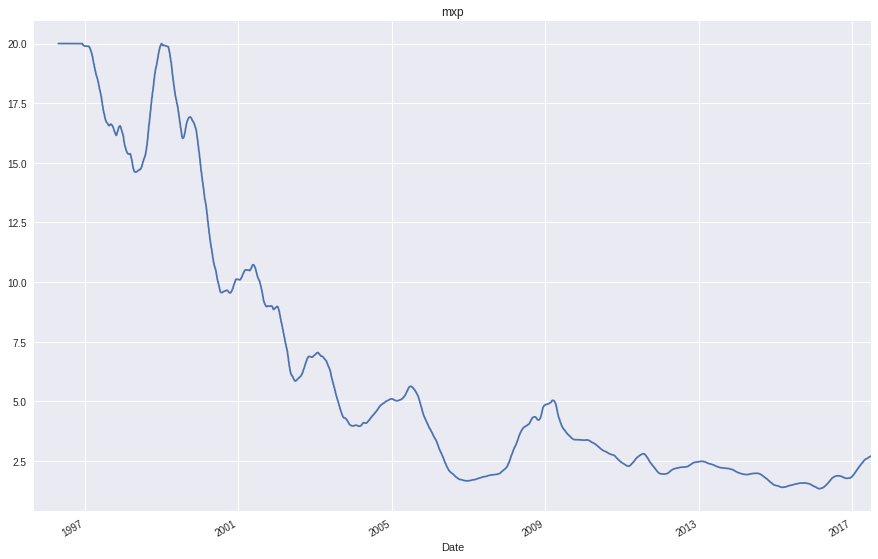

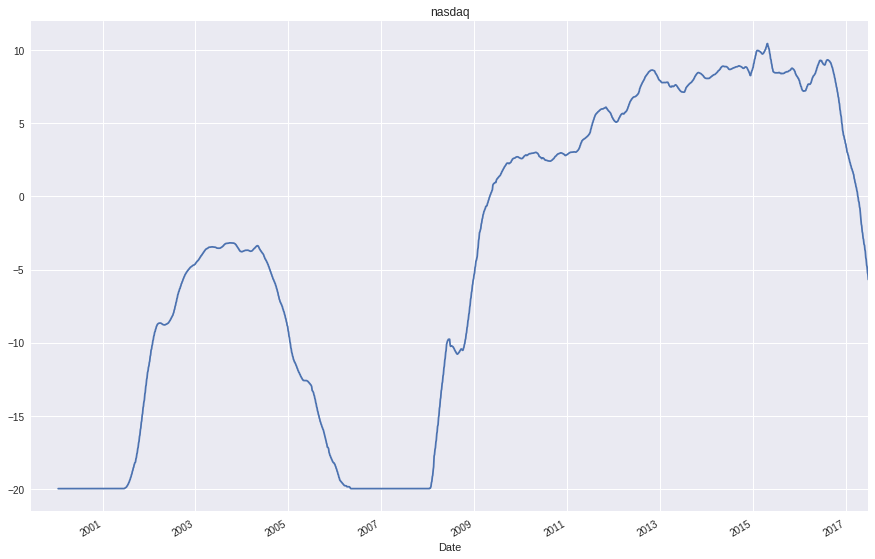

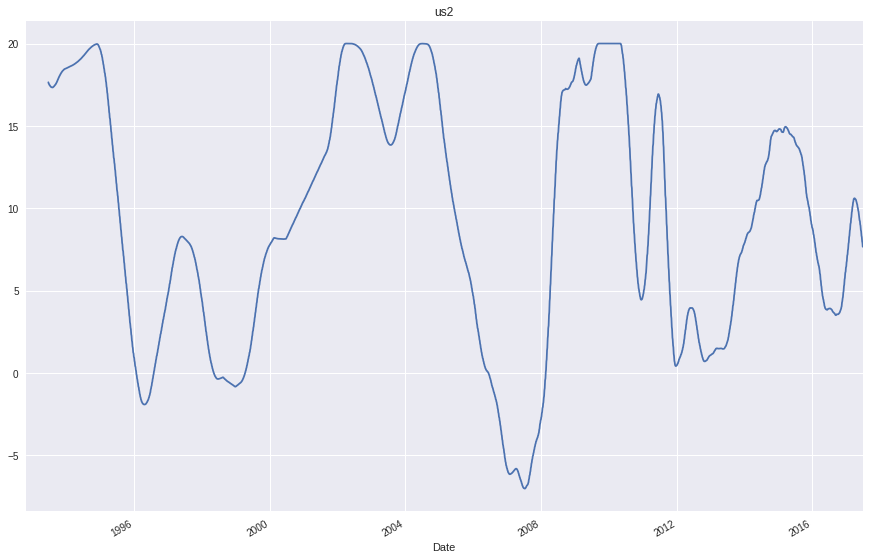

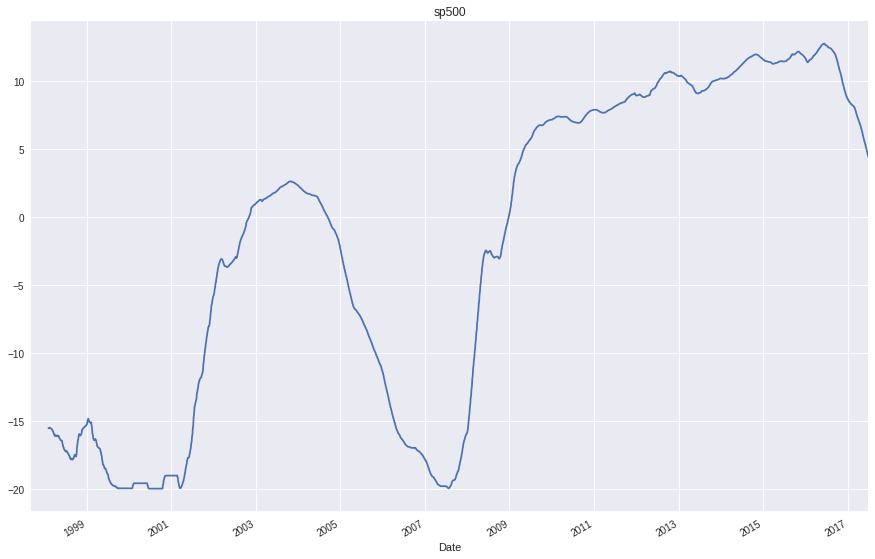

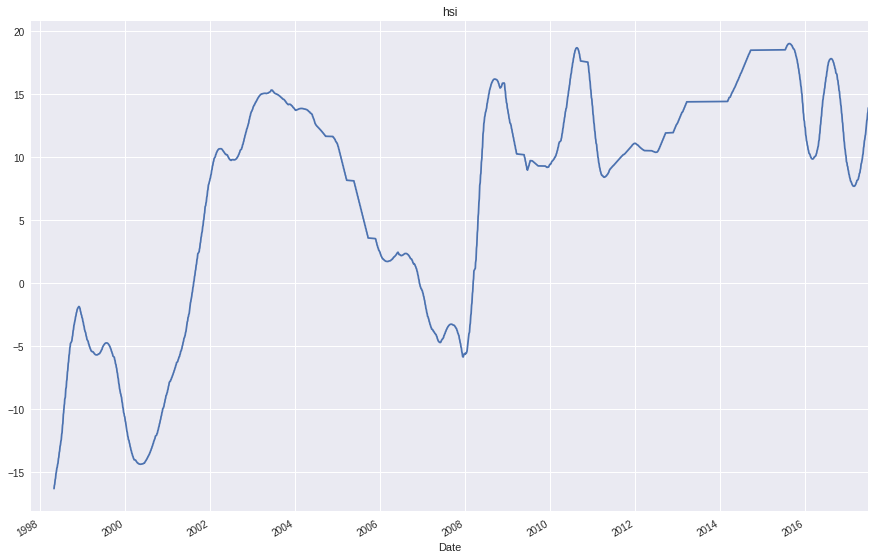

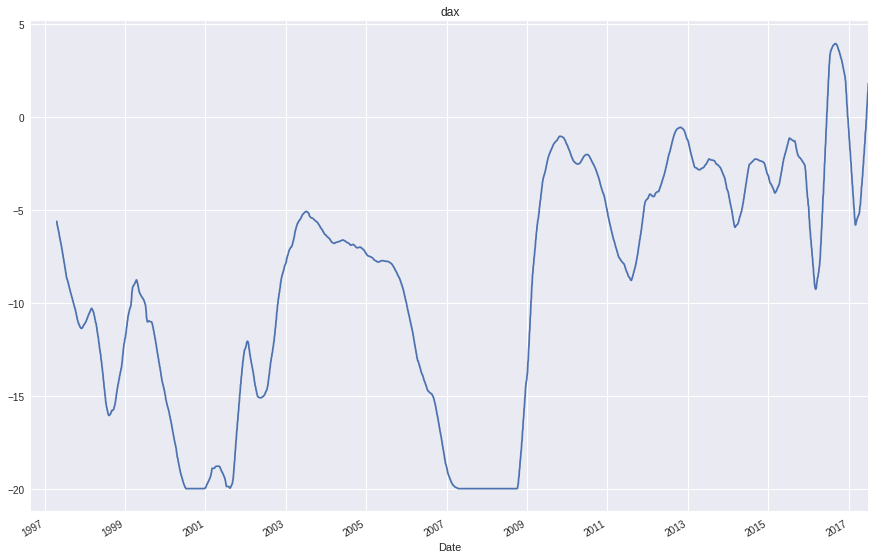

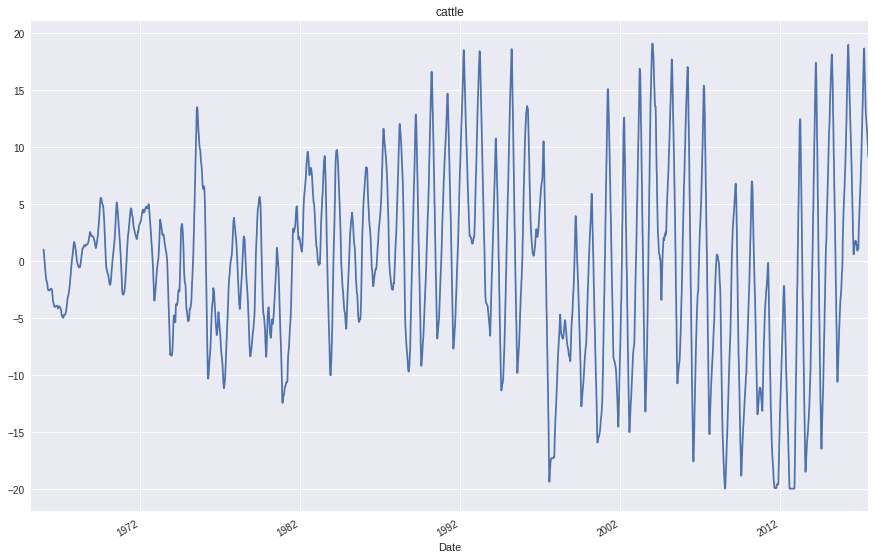

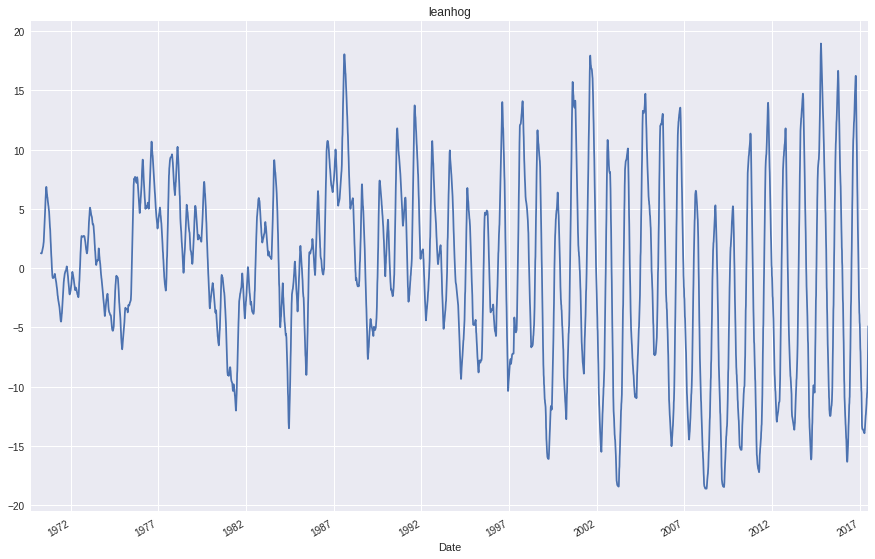

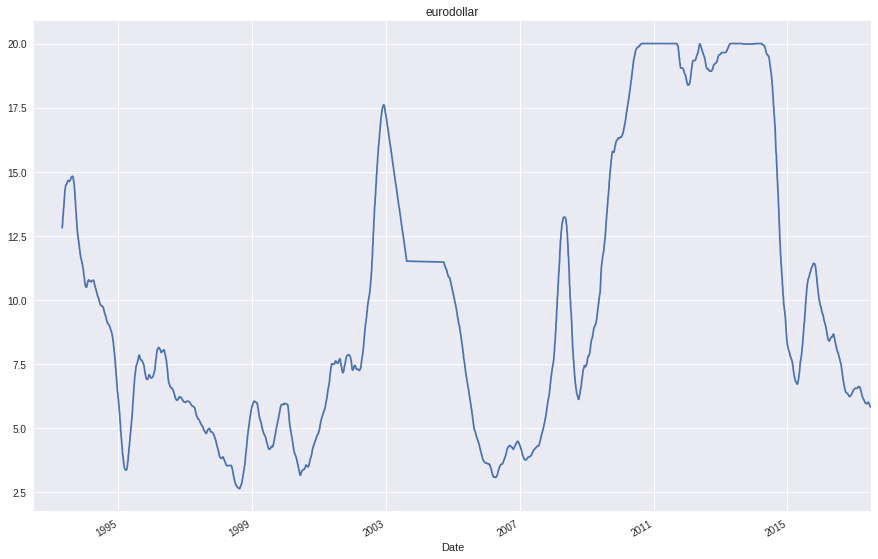

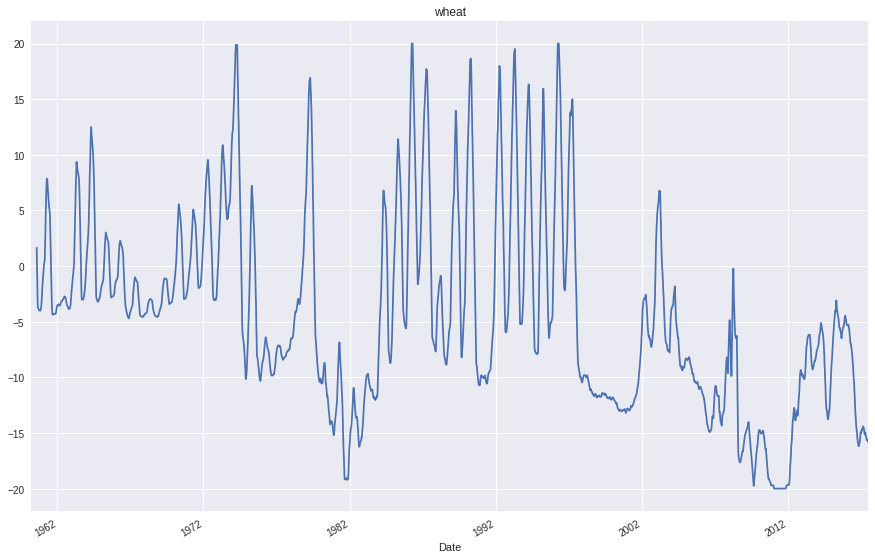

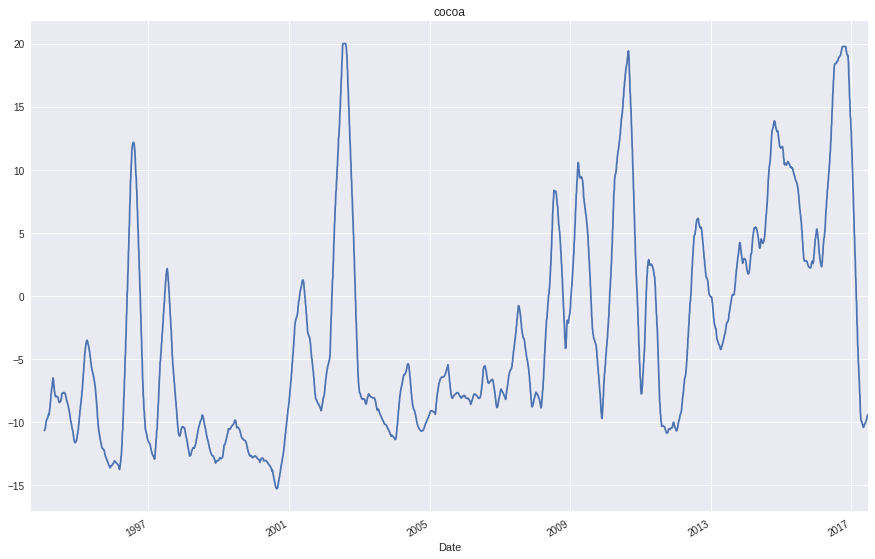

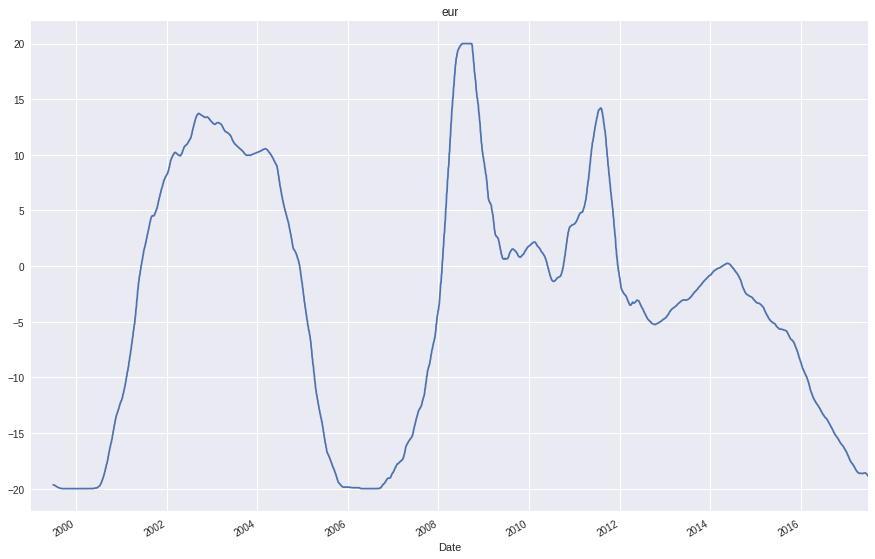

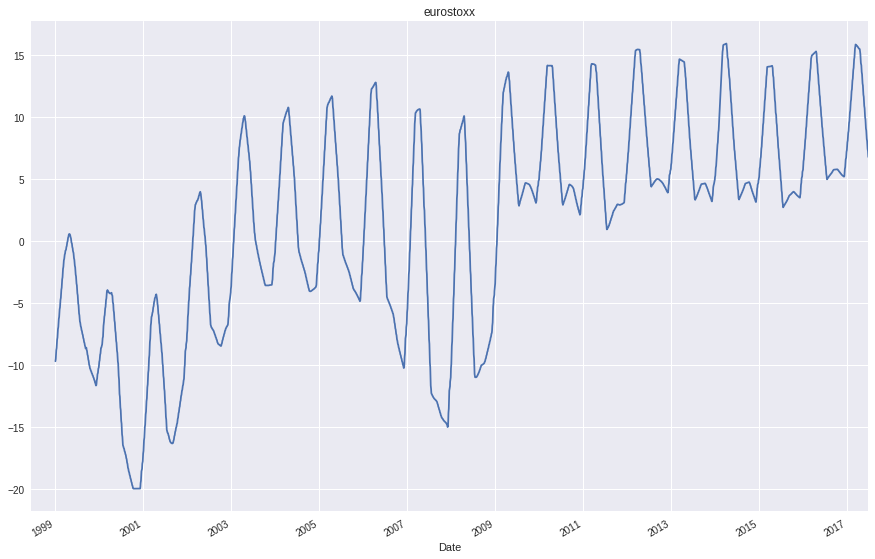

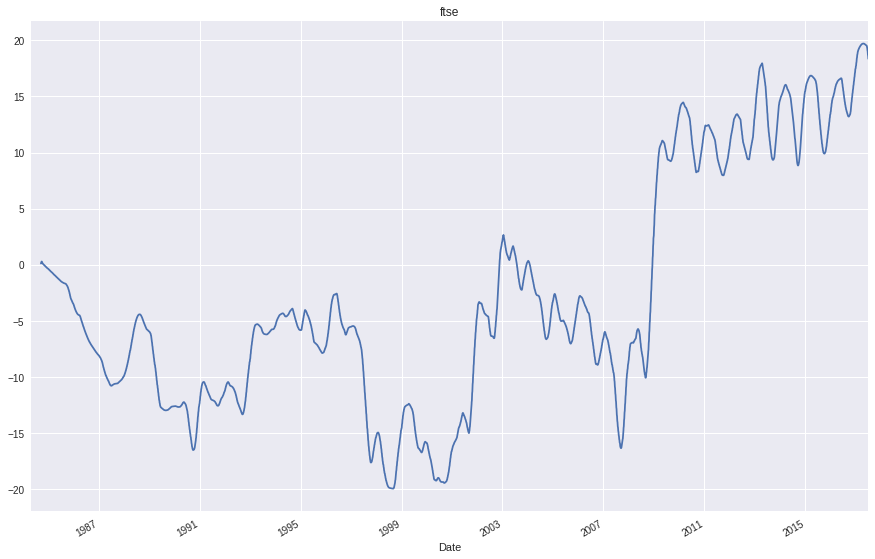

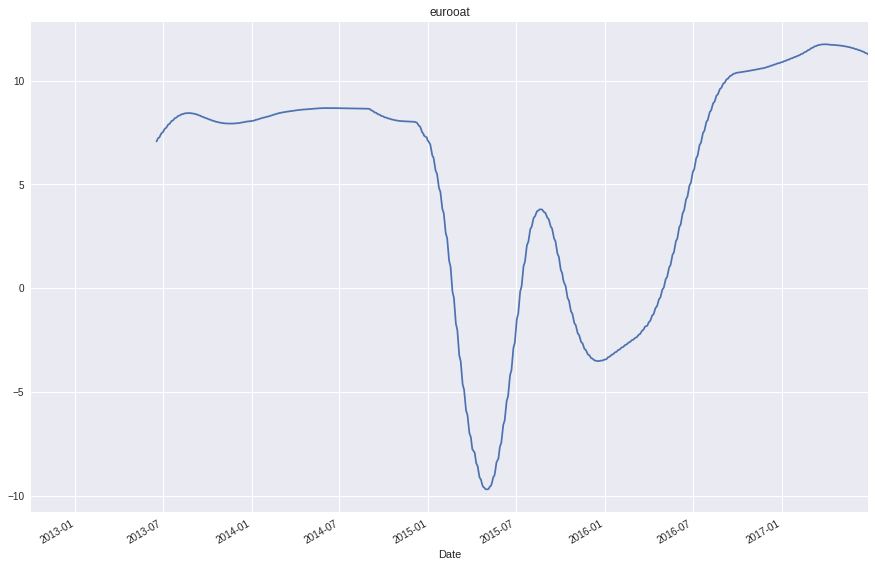

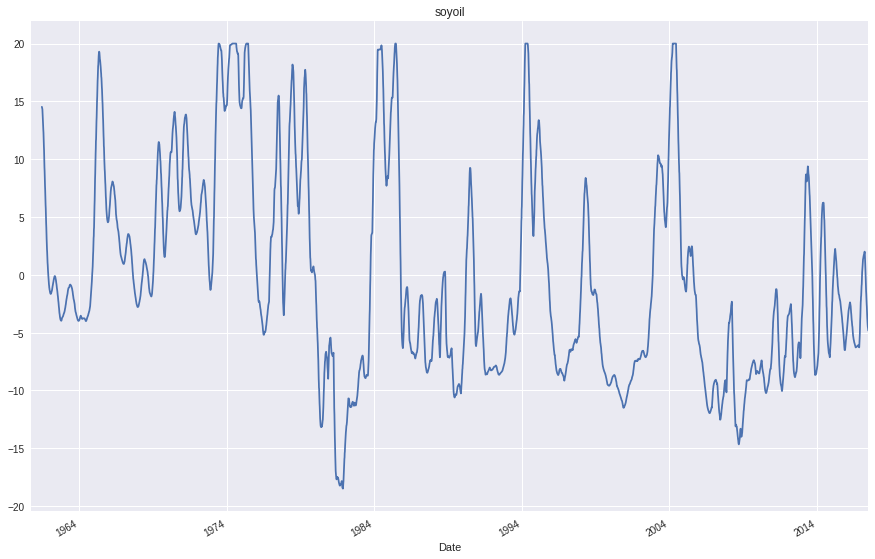

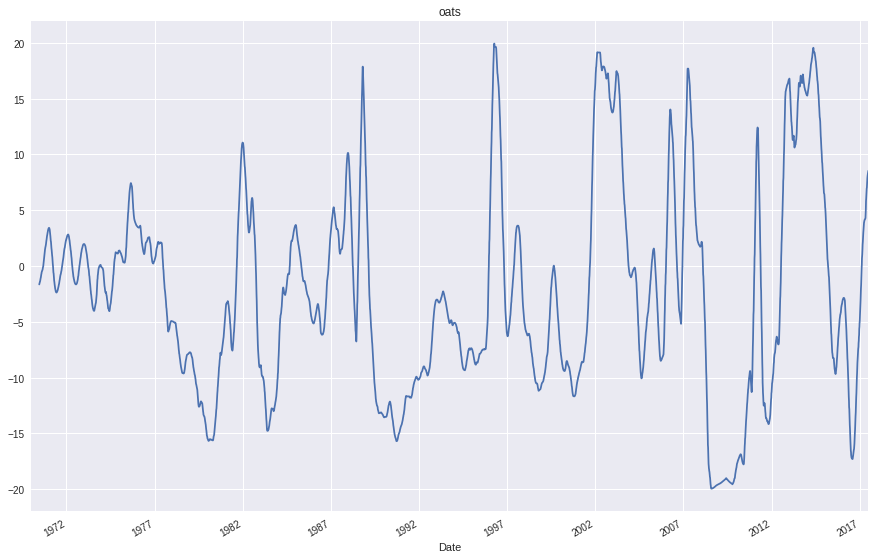

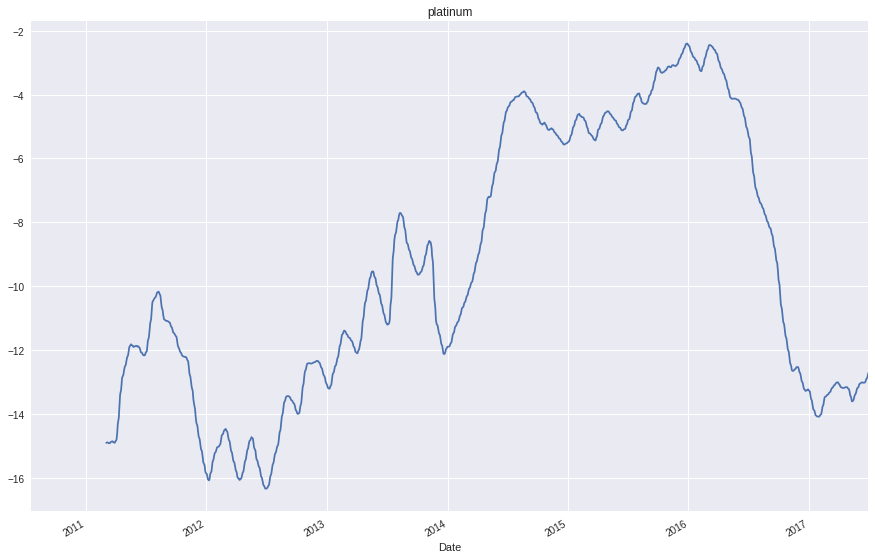

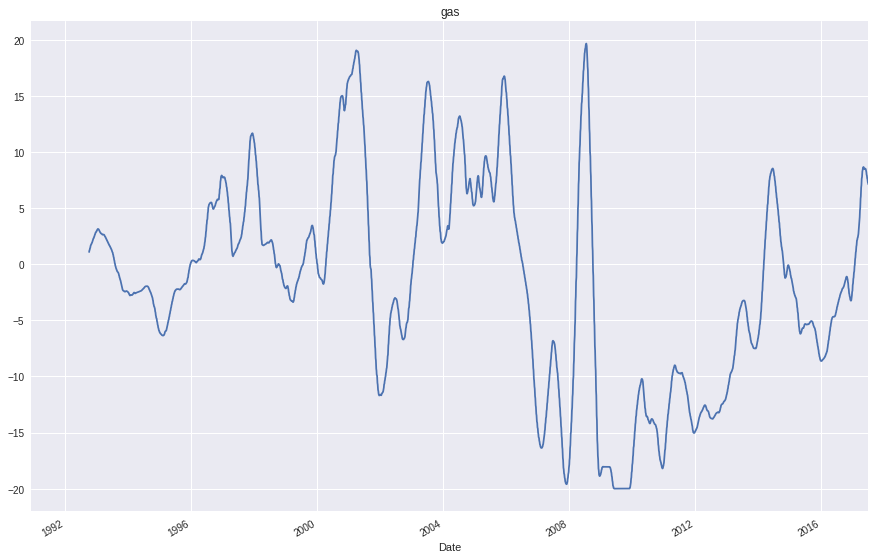

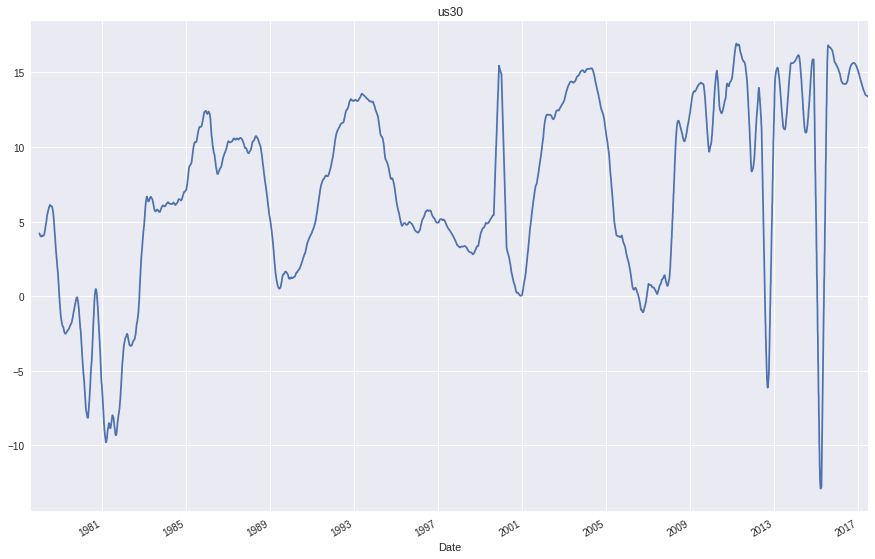

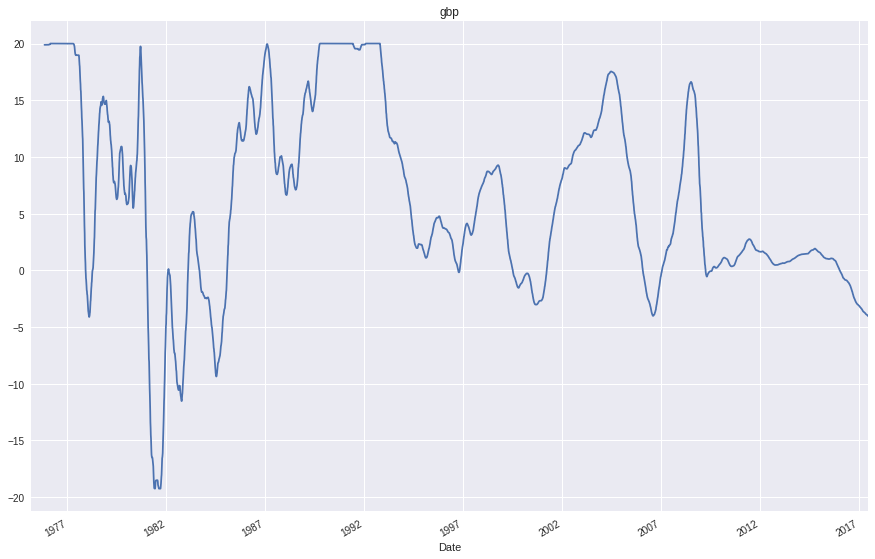

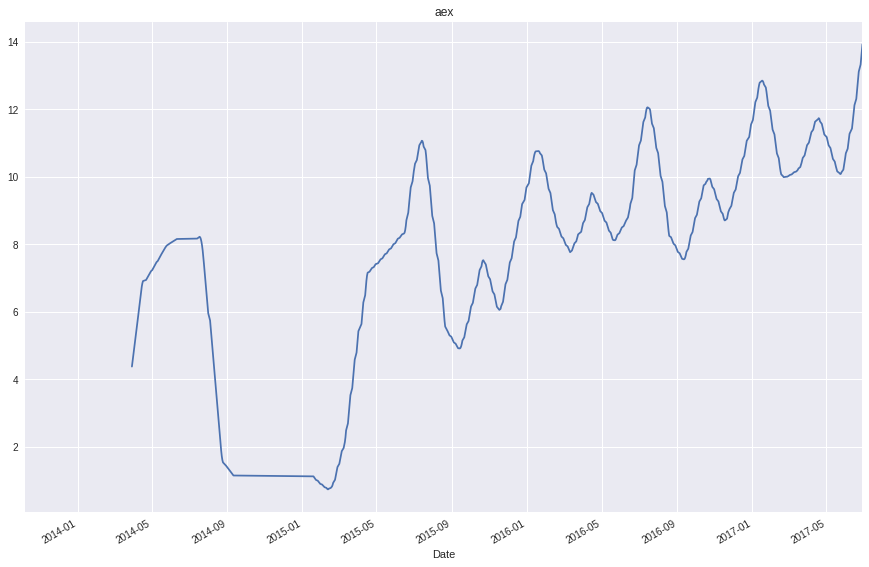

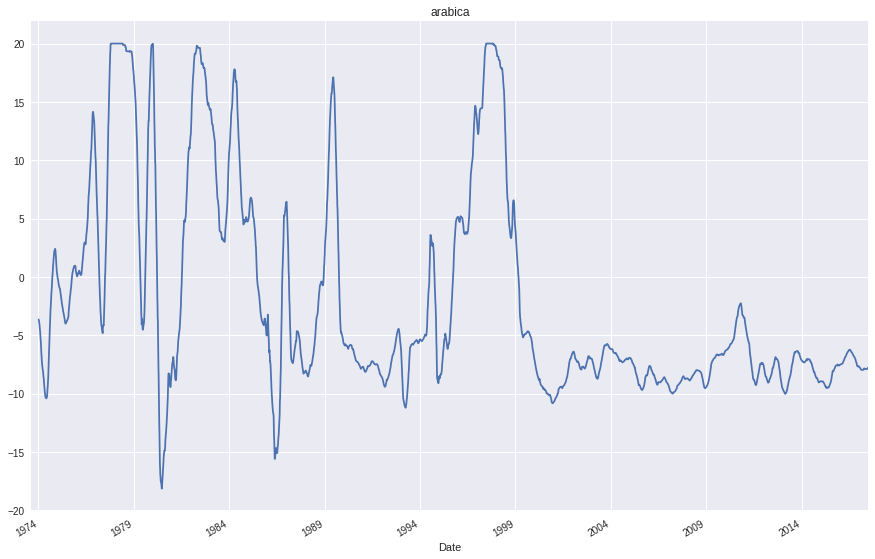

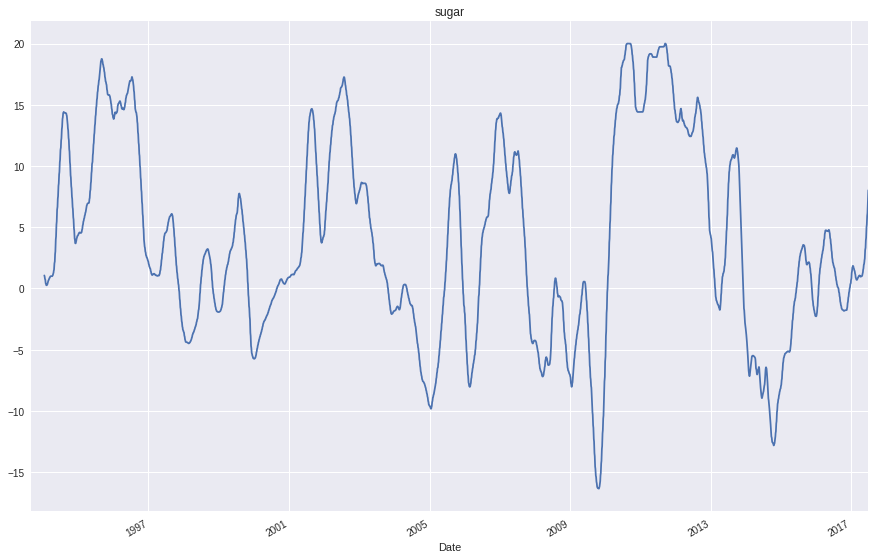

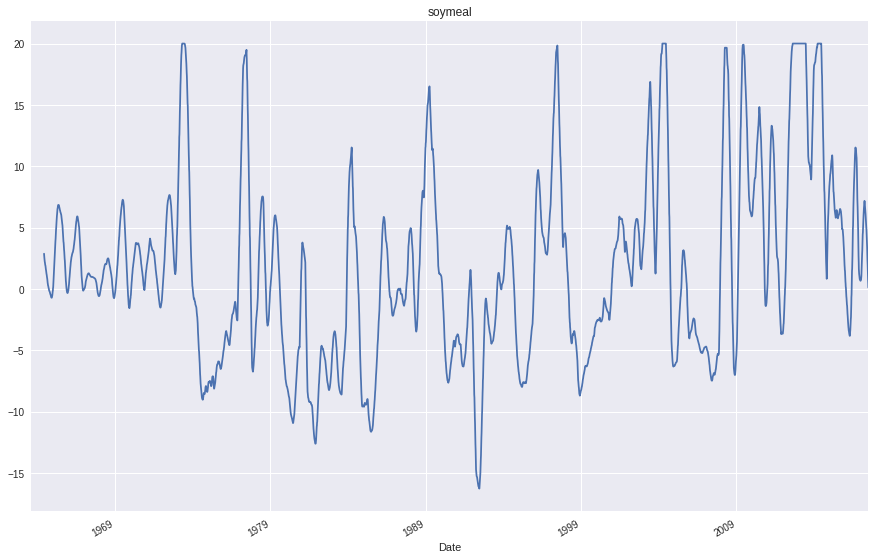

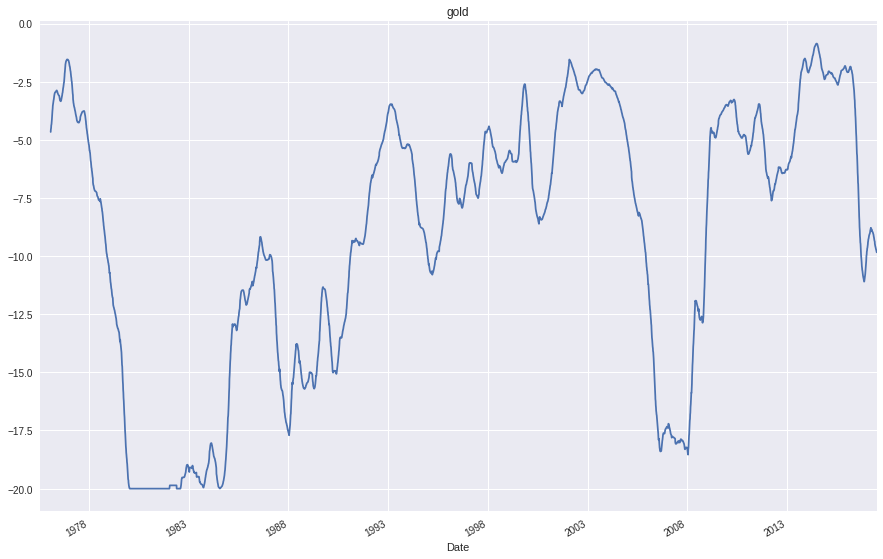

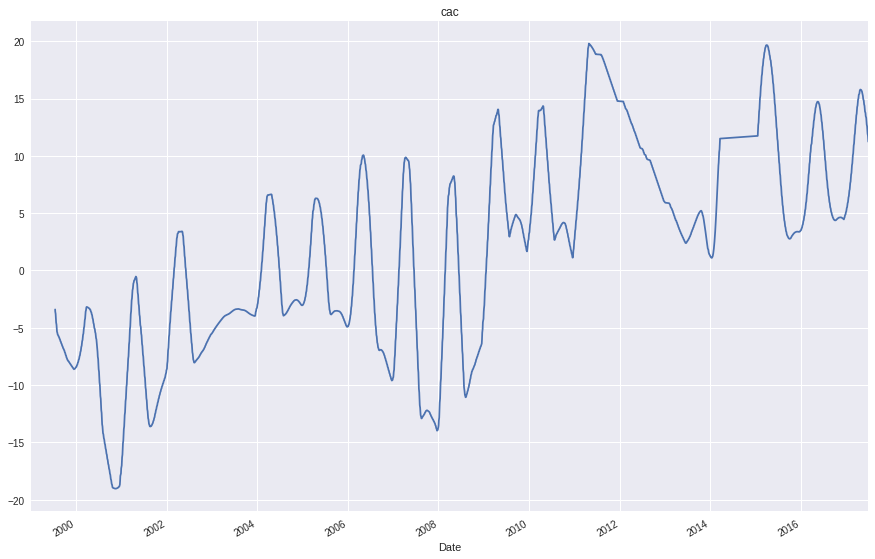

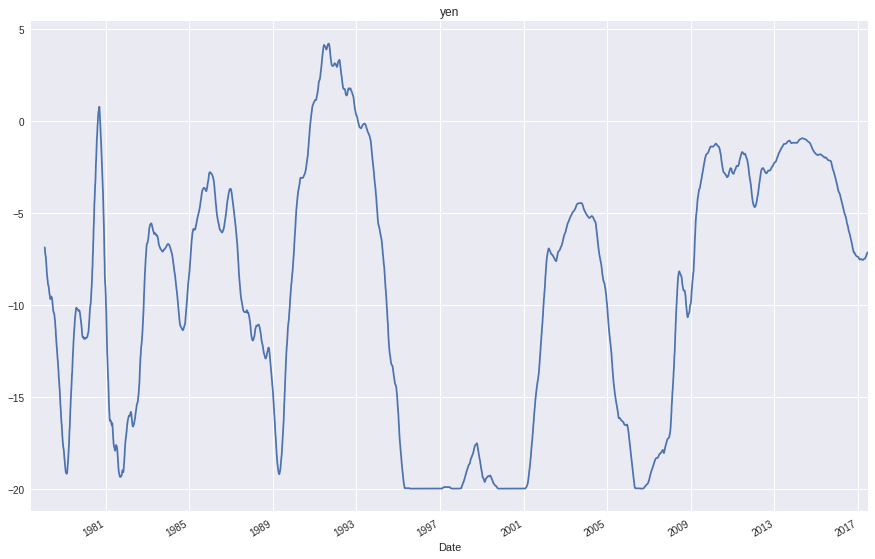

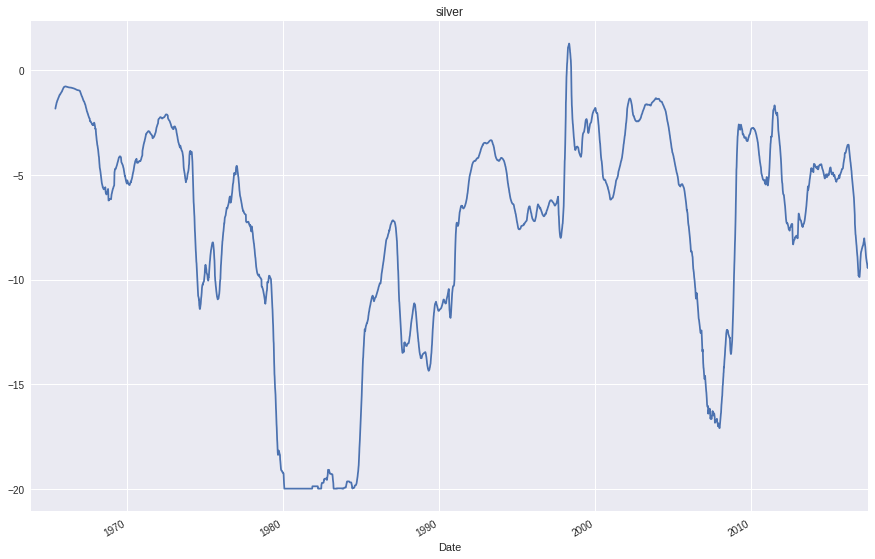

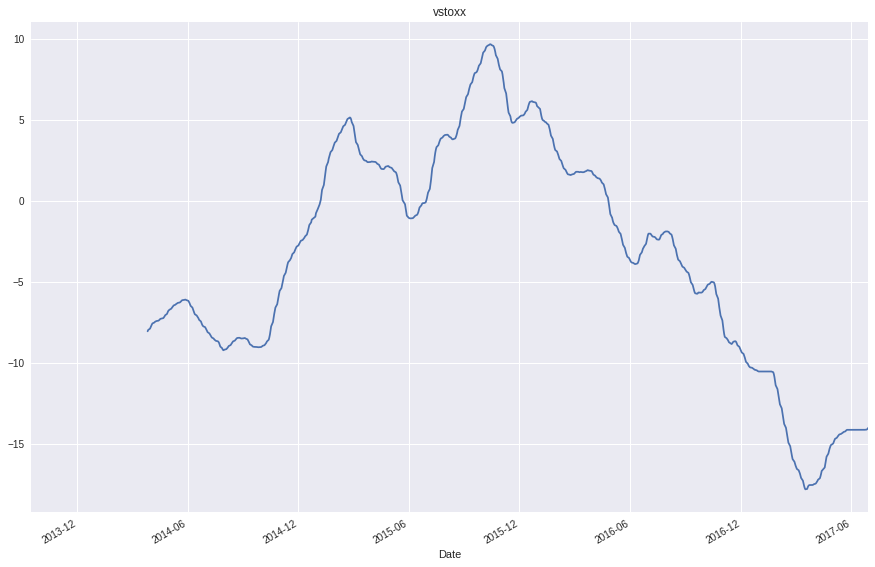

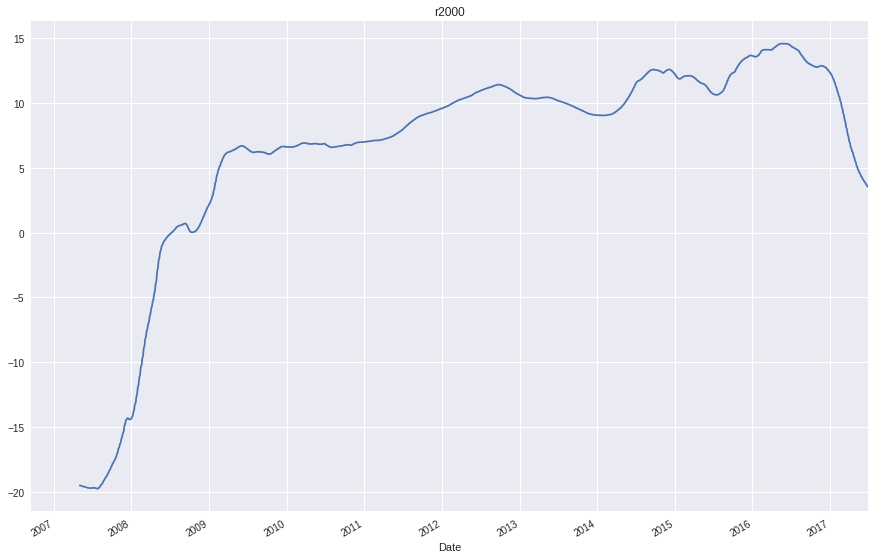

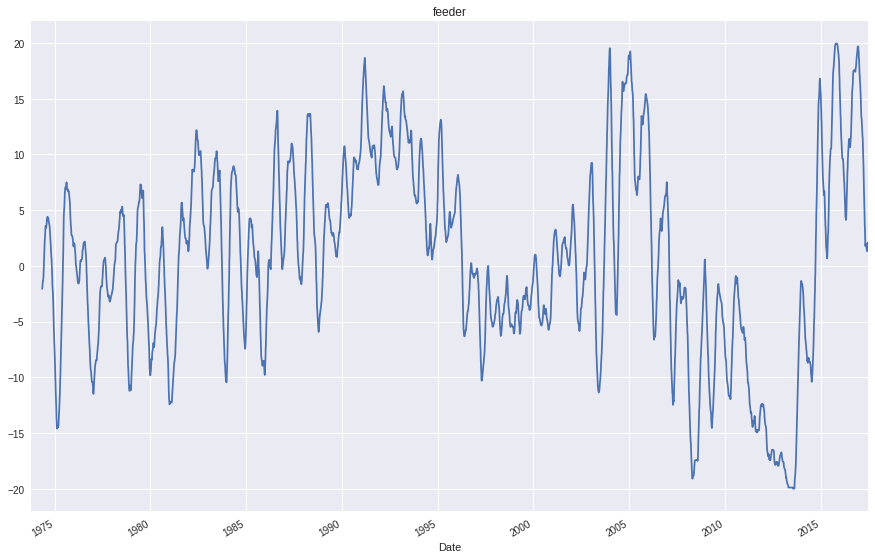

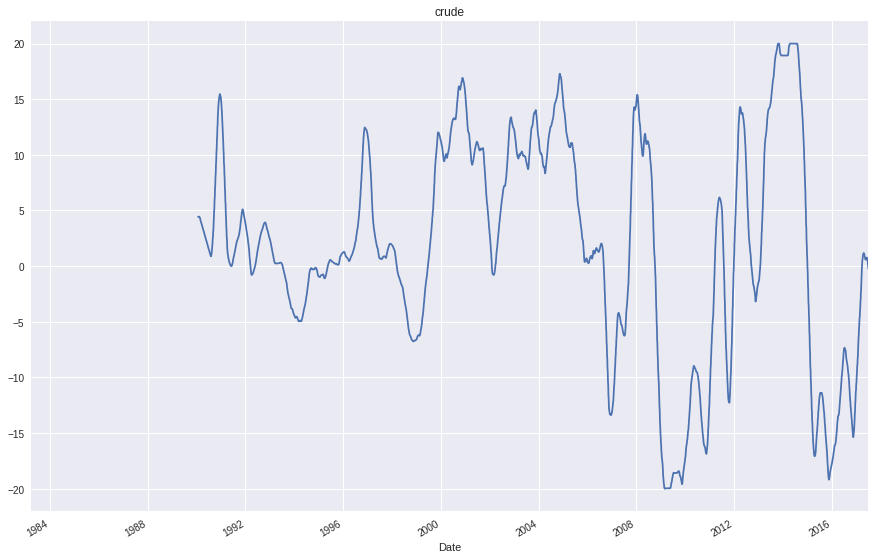

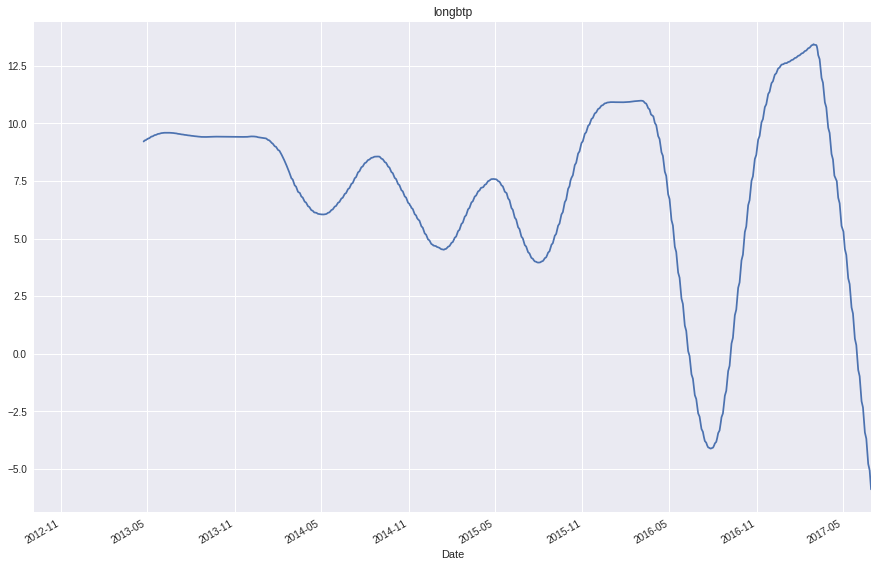

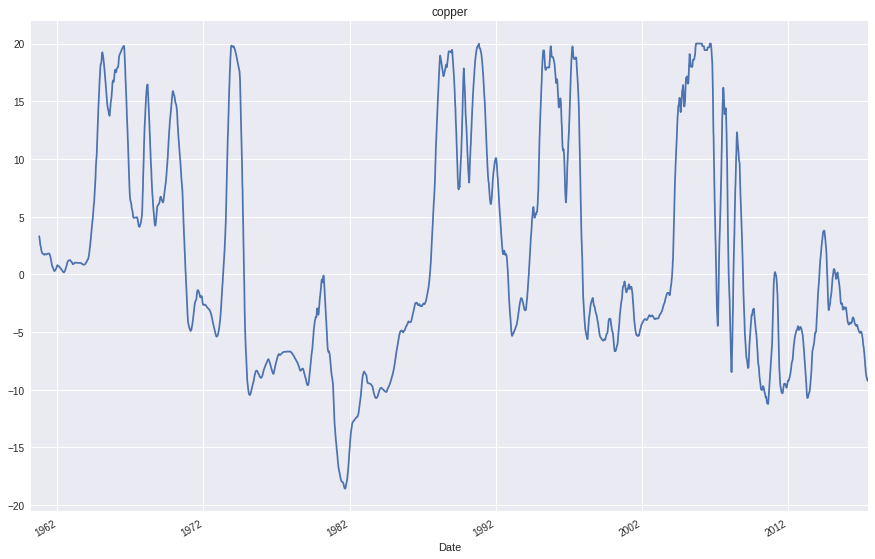

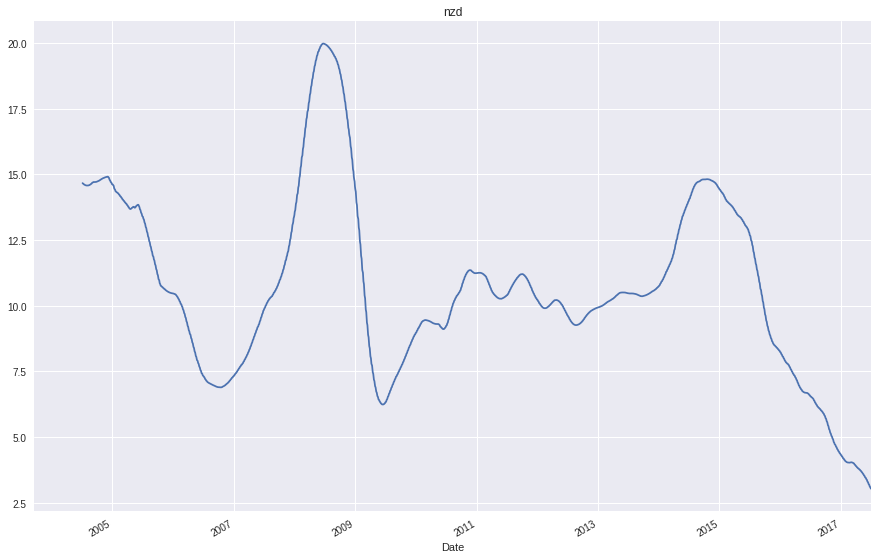

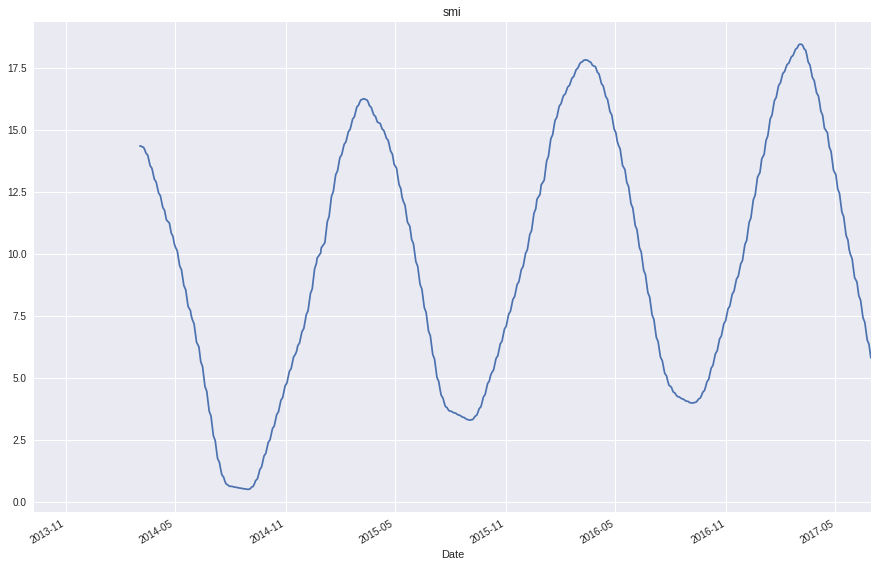

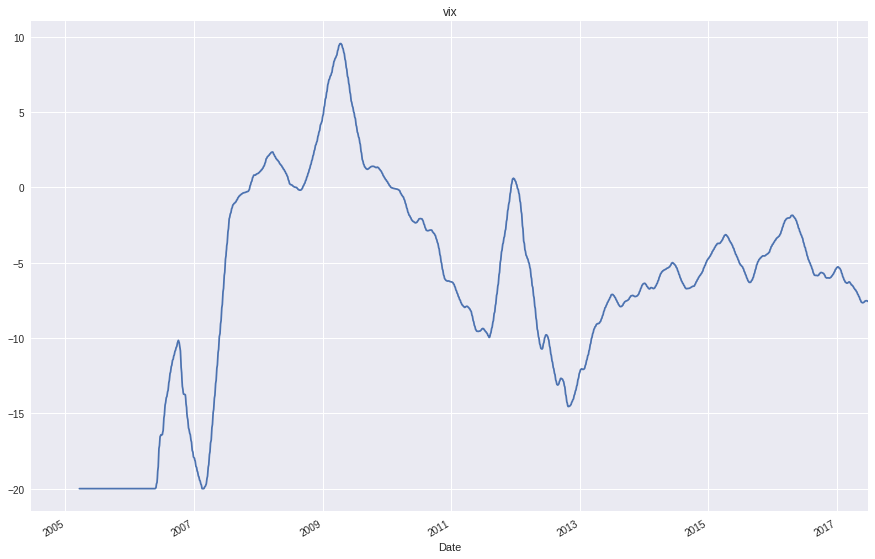

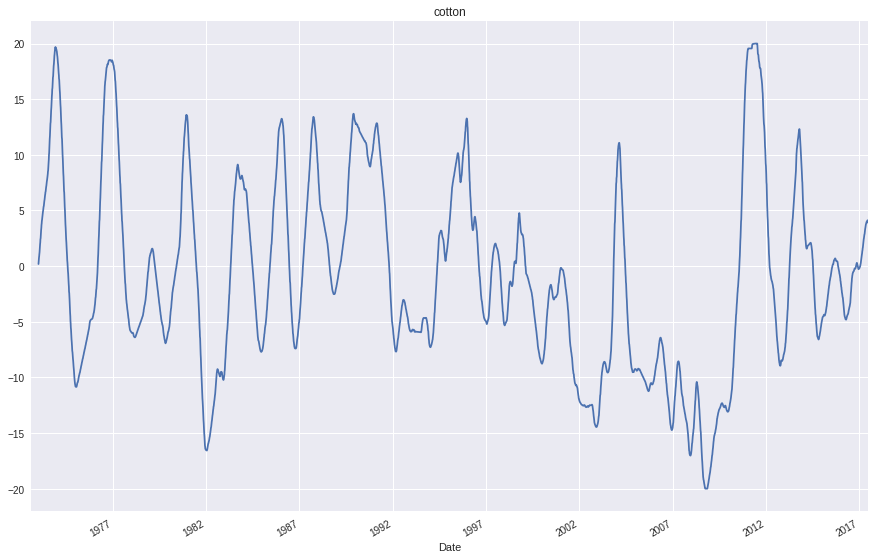

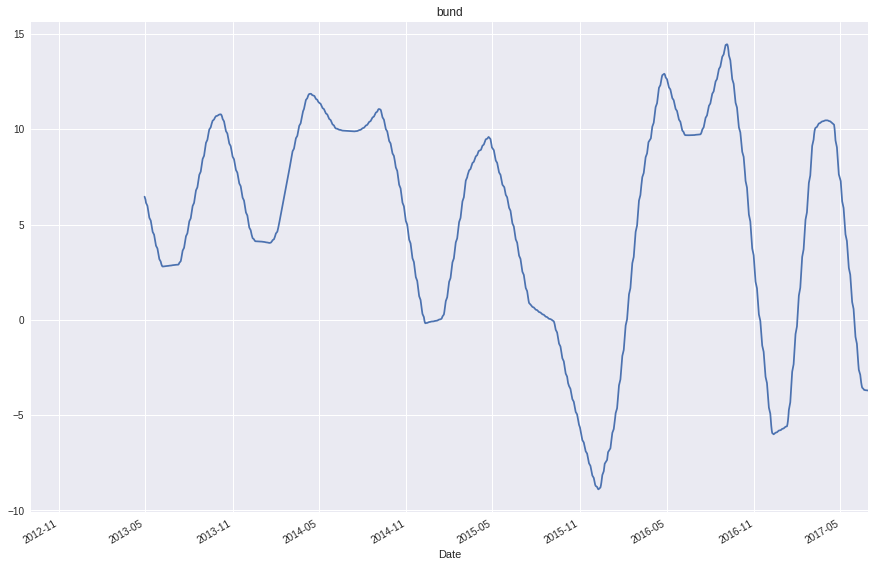

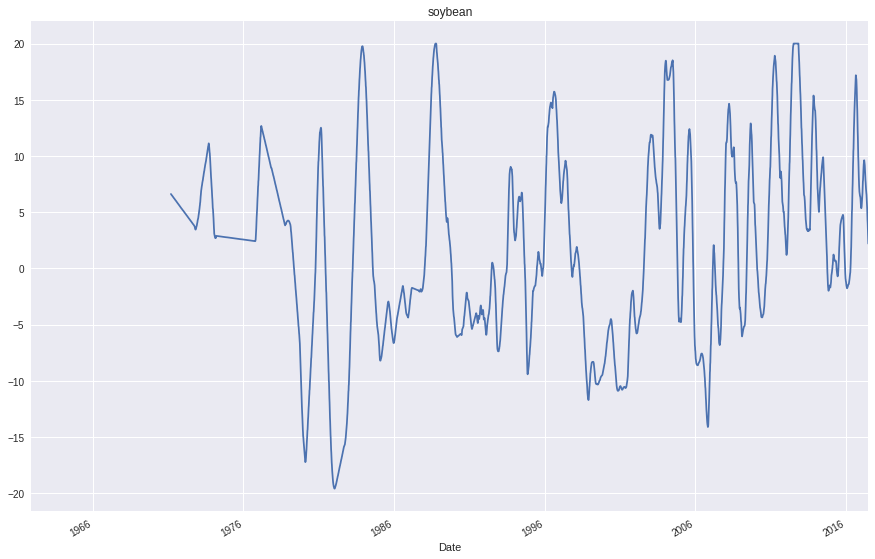

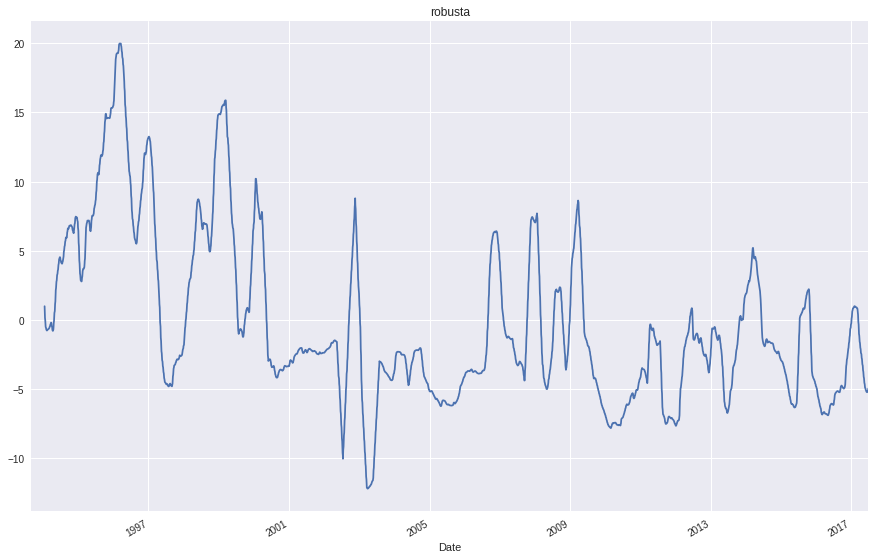

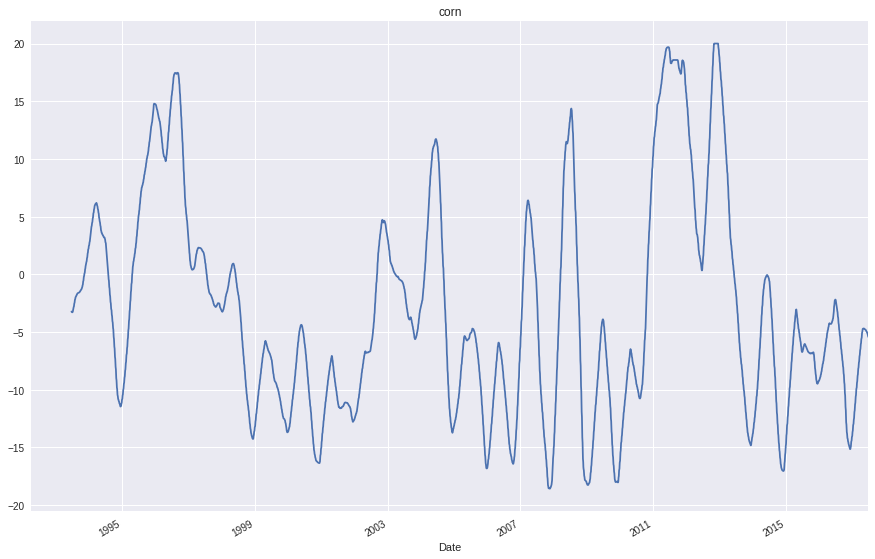

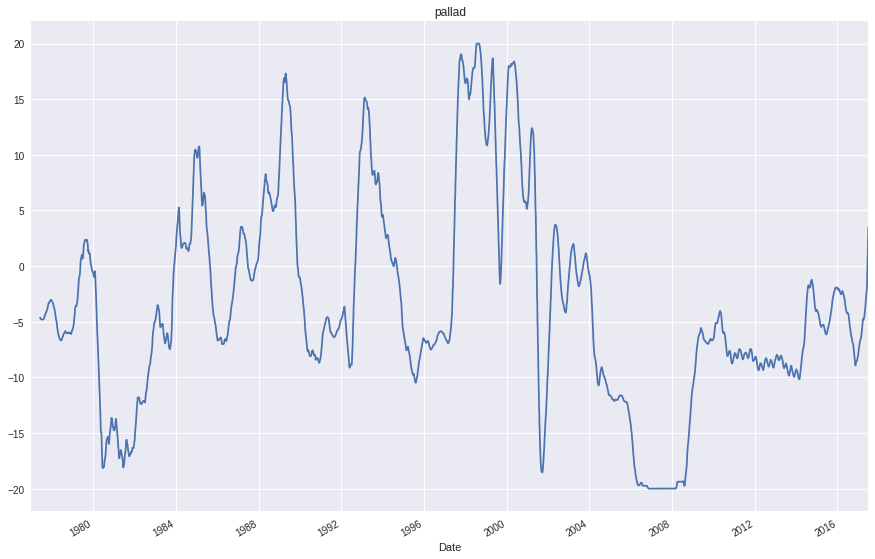

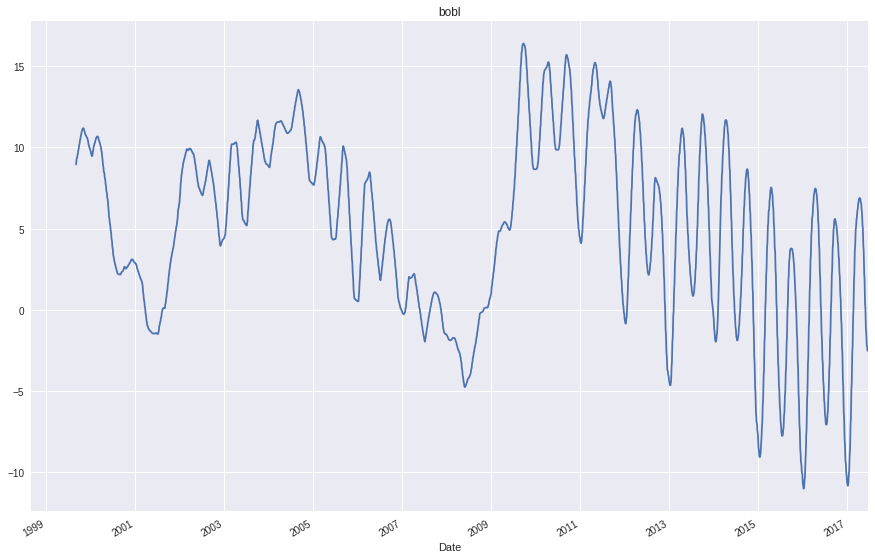

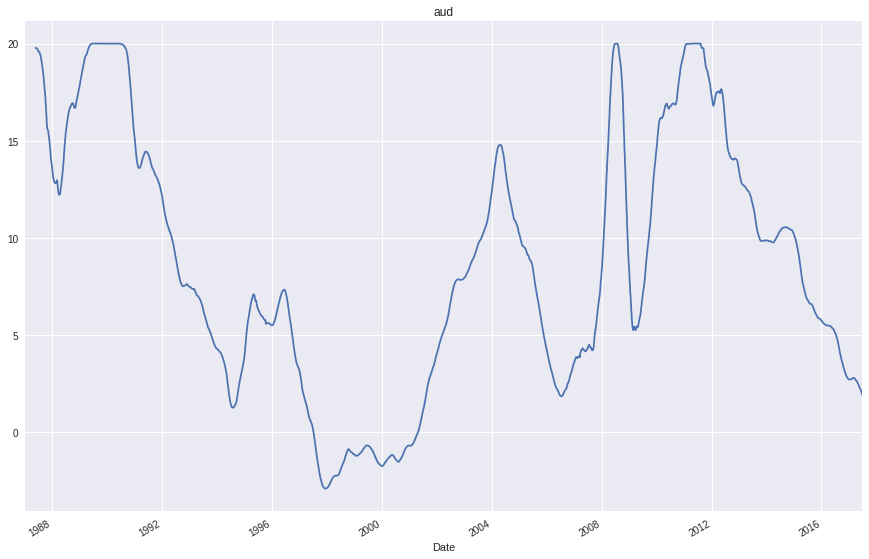

In [8]:
from core.rules import carry_next
import matplotlib.pyplot as plt
for k in i.values():
    carry_next(k).plot(title=k.name)
    plt.show()

In [35]:
i['smi'].forecast_returns()['carry_next']

Date
1991-03-05             NaN
1991-03-06             NaN
1991-03-07             NaN
1991-03-08             NaN
1991-03-09             NaN
1991-03-10             NaN
1991-03-11             NaN
1991-03-12             NaN
1991-03-13             NaN
1991-03-14        0.000000
1991-03-15        0.000000
1991-03-16             NaN
1991-03-17             NaN
1991-03-18        0.000000
1991-03-19        0.000000
1991-03-20        0.000000
1991-03-21        0.000000
1991-03-22        0.000000
1991-03-23             NaN
1991-03-24             NaN
1991-03-25        0.000000
1991-03-26        0.000000
1991-03-27        0.000000
1991-03-28        0.000000
1991-03-29        0.000000
1991-03-30             NaN
1991-03-31             NaN
1991-04-01        0.000000
1991-04-02        0.000000
1991-04-03        0.000000
                  ...     
2017-05-19     8581.500453
2017-05-22     6399.774108
2017-05-23    -2804.788483
2017-05-24    -1363.972640
2017-05-25       -2.544029
2017-05-26      983.232